In [18]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import logging

In [19]:
# 设置随机种子
seed_num = 42
os.environ['PYTHONHASHSEED'] = str(seed_num)
random.seed(seed_num)
np.random.seed(seed_num)
torch.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)
torch.backends.cudnn.deterministic = True

In [20]:
# 读取数据
data = pd.read_csv('data/baoli.csv', skiprows=2)
data = data[(data != 0).all(axis=1)]

# 计算指标
data['SMA_5'] = data['close'].rolling(window=5).mean()
data['SMA_10'] = data['close'].rolling(window=10).mean()
data['EMA_12'] = data['close'].ewm(span=12, adjust=False).mean()
data['EMA_26'] = data['close'].ewm(span=26, adjust=False).mean()
data['MACD'] = data['EMA_12'] - data['EMA_26']
data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

def calculate_rsi(data, window):
    delta = data['close'].diff(1)
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(window=window).mean()
    avg_loss = pd.Series(loss).rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

data['RSI_14'] = calculate_rsi(data, 14)
data.dropna(inplace=True)
print(data.head())

# 选择特征
all_data = data.loc[:, ['open', 'close', 'high', 'low', 'volume', 'SMA_5', 'SMA_10', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'RSI_14']]
print(all_data.info())

         date  open  close  high   low     volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  7.47   7.54  7.65  7.46   29716953  7.492   7.539  7.612695   
14  2014/1/22  7.60   8.09  8.18  7.57  112607381  7.610   7.597  7.686126   
15  2014/1/23  8.06   7.94  8.14  7.88   61624651  7.692   7.625  7.725184   
16  2014/1/24  7.90   8.18  8.42  7.87   90084256  7.838   7.677  7.795155   
17  2014/1/27  8.10   8.04  8.15  7.95   50544304  7.958   7.729  7.832824   

      EMA_26      MACD  Signal_Line     RSI_14  
13  7.791581 -0.178886    -0.155633  25.757576  
14  7.813686 -0.127560    -0.150019  47.593583  
15  7.823043 -0.097859    -0.139587  45.641026  
16  7.849484 -0.054328    -0.122535  65.317919  
17  7.863596 -0.030772    -0.104182  62.777778  
<class 'pandas.core.frame.DataFrame'>
Index: 2407 entries, 13 to 2426
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open         2407 non-null   float64
 1   clo

In [21]:
# 数据归一化
sc = MinMaxScaler(feature_range=(0, 1))
all_data_scaled = sc.fit_transform(all_data)
print('训练数据长度是:', len(all_data_scaled))

训练数据长度是: 2407


In [22]:
# 数据准备
timestep = 60
features, labels = [], []
for i in range(timestep, len(all_data_scaled)):
    features.append(all_data_scaled[i - timestep:i])
    labels.append(all_data_scaled[i, 1])

features, labels = np.array(features), np.array(labels)
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

In [23]:
# 数据集划分
train_size = int(len(features) * 0.8)
val_size = int(len(features) * 0.1)

x_train, y_train = features[:train_size], labels[:train_size]
x_val, y_val = features[train_size:train_size+val_size], labels[train_size:train_size+val_size]
x_test, y_test = features[train_size+val_size:], labels[train_size+val_size:]

print(f'shape of x_train: {x_train.shape}')
print(f'shape of x_val: {x_val.shape}')
print(f'shape of x_test: {x_test.shape}')

shape of x_train: torch.Size([1877, 60, 12])
shape of x_val: torch.Size([234, 60, 12])
shape of x_test: torch.Size([236, 60, 12])


In [24]:
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

input_size = 12
hidden_size = 50
num_layers = 4
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
# 模型训练
num_epochs = 100
batch_size = 32

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [26]:
history = {'loss': [], 'val_loss': []}
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch 1/100, Loss: 0.0348, Val Loss: 0.0176
Epoch 2/100, Loss: 0.0051, Val Loss: 0.0035
Epoch 3/100, Loss: 0.0033, Val Loss: 0.0020
Epoch 4/100, Loss: 0.0031, Val Loss: 0.0018
Epoch 5/100, Loss: 0.0025, Val Loss: 0.0028
Epoch 6/100, Loss: 0.0029, Val Loss: 0.0027
Epoch 7/100, Loss: 0.0027, Val Loss: 0.0020
Epoch 8/100, Loss: 0.0023, Val Loss: 0.0020
Epoch 9/100, Loss: 0.0025, Val Loss: 0.0022
Epoch 10/100, Loss: 0.0022, Val Loss: 0.0035
Epoch 11/100, Loss: 0.0021, Val Loss: 0.0037
Epoch 12/100, Loss: 0.0022, Val Loss: 0.0019
Epoch 13/100, Loss: 0.0019, Val Loss: 0.0019
Epoch 14/100, Loss: 0.0021, Val Loss: 0.0016
Epoch 15/100, Loss: 0.0020, Val Loss: 0.0015
Epoch 16/100, Loss: 0.0020, Val Loss: 0.0034
Epoch 17/100, Loss: 0.0021, Val Loss: 0.0057
Epoch 18/100, Loss: 0.0022, Val Loss: 0.0016
Epoch 19/100, Loss: 0.0019, Val Loss: 0.0026
Epoch 20/100, Loss: 0.0020, Val Loss: 0.0018
Epoch 21/100, Loss: 0.0017, Val Loss: 0.0018
Epoch 22/100, Loss: 0.0017, Val Loss: 0.0015
Epoch 23/100, Loss:

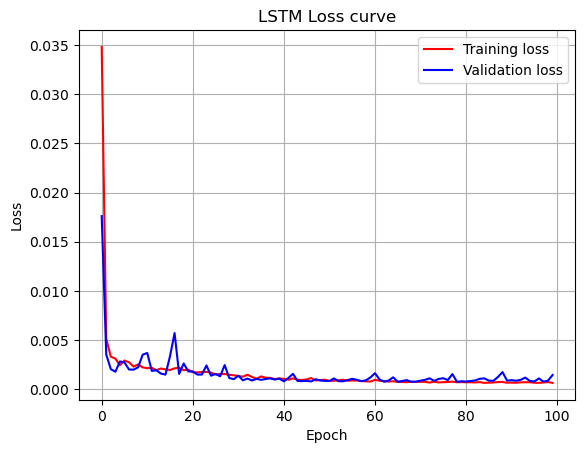

In [27]:
# 绘制损失曲线
plt.title('LSTM Loss curve')
plt.plot(history['loss'], 'red', label='Training loss')
plt.plot(history['val_loss'], 'blue', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [28]:
# 预测并逆归一化
model.eval()
sc_one = MinMaxScaler(feature_range=(0, 1))
sc_one.fit(all_data.iloc[:, 1:2])

predicted_stock_train = model(x_train).detach().numpy()
predicted_stock_train = sc_one.inverse_transform(predicted_stock_train)
predicted_stock_test = model(x_test).detach().numpy()
predicted_stock_test = sc_one.inverse_transform(predicted_stock_test)

real_price_train = sc_one.inverse_transform(y_train.numpy())
real_price_test = sc_one.inverse_transform(y_test.numpy())

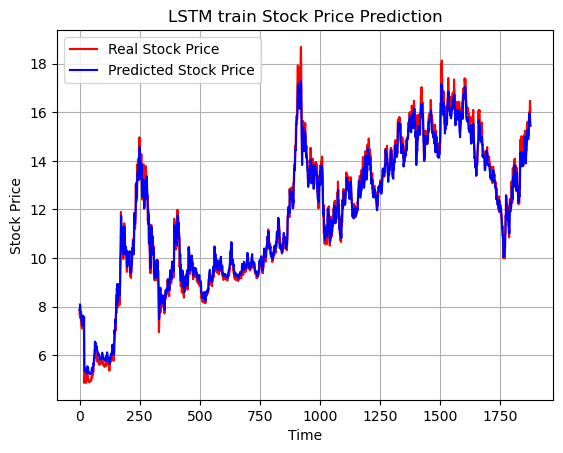

In [29]:
# 可视化结果
plt.plot(real_price_train, color='red', label='Real Stock Price')
plt.plot(predicted_stock_train, color='blue', label='Predicted Stock Price')
plt.title('LSTM train Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

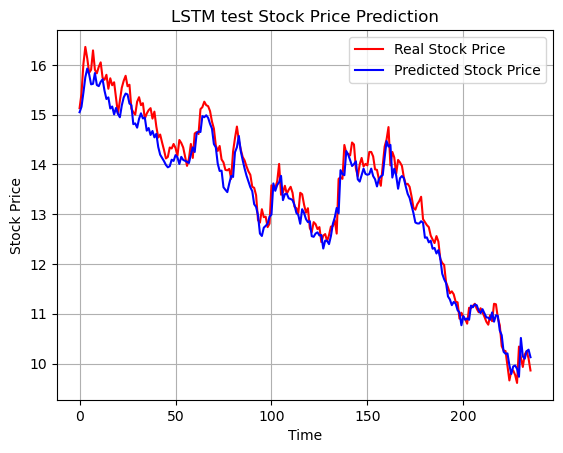

In [30]:
plt.plot(real_price_test, color='red', label='Real Stock Price')
plt.plot(predicted_stock_test, color='blue', label='Predicted Stock Price')
plt.title('LSTM test Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# 评价指标
mse = mean_squared_error(predicted_stock_test, real_price_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(predicted_stock_test, real_price_test)
mape = mean_absolute_percentage_error(predicted_stock_test, real_price_test)
r2 = r2_score(predicted_stock_test, real_price_test)

print(f'MSE: {mse:.6f}')
print(f'RMSE: {rmse:.6f}')
print(f'MAE: {mae:.6f}')
print(f'MAPE: {mape:.6f}')
print(f'R^2: {r2:.6f}')

MSE: 0.076807
RMSE: 0.277141
MAE: 0.225469
MAPE: 0.016855
R^2: 0.966903


         date  open  close  high   low     volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  7.47   7.54  7.65  7.46   29716953  7.492   7.539  7.612695   
14  2014/1/22  7.60   8.09  8.18  7.57  112607381  7.610   7.597  7.686126   
15  2014/1/23  8.06   7.94  8.14  7.88   61624651  7.692   7.625  7.725184   
16  2014/1/24  7.90   8.18  8.42  7.87   90084256  7.838   7.677  7.795155   
17  2014/1/27  8.10   8.04  8.15  7.95   50544304  7.958   7.729  7.832824   

      EMA_26      MACD  Signal_Line     RSI_14  
13  7.791581 -0.178886    -0.155633  25.757576  
14  7.813686 -0.127560    -0.150019  47.593583  
15  7.823043 -0.097859    -0.139587  45.641026  
16  7.849484 -0.054328    -0.122535  65.317919  
17  7.863596 -0.030772    -0.104182  62.777778  
Epoch 1/20, Loss: 0.1074, Val Loss: 0.0377
Epoch 2/20, Loss: 0.0378, Val Loss: 0.0579
Epoch 3/20, Loss: 0.0237, Val Loss: 0.0058
Epoch 4/20, Loss: 0.0094, Val Loss: 0.0096
Epoch 5/20, Loss: 0.0072, Val Loss: 0.0086
Epoch 6/20, Loss: 0.00

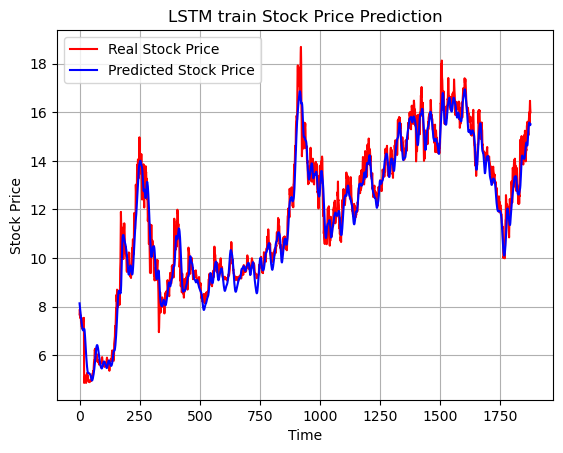

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  20.81  20.93  21.18  20.61  12184644  21.312  21.478   
14  2014/1/22  20.96  21.61  21.70  20.82  25494231  21.342  21.454   
15  2014/1/23  21.58  21.32  21.58  21.23  17370777  21.204  21.435   
16  2014/1/24  21.20  21.56  21.85  21.15  21505122  21.246  21.441   
17  2014/1/27  21.39  21.28  21.54  21.20  14955803  21.340  21.400   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  21.526832  21.785813 -0.258981    -0.145170  35.764706  
14  21.539627  21.772790 -0.233163    -0.162769  44.624746  
15  21.505838  21.739250 -0.233411    -0.176897  33.771930  
16  21.514171  21.725972 -0.211801    -0.183878  39.555556  
17  21.478145  21.692937 -0.214792    -0.190061  40.546697  
Epoch 1/20, Loss: 0.0351, Val Loss: 0.0738
Epoch 2/20, Loss: 0.0154, Val Loss: 0.0131
Epoch 3/20, Loss: 0.0042, Val Loss: 0.0060
Epoch 4/20, Loss: 0.0026, Val Loss: 0.0093
Epoch 5/20, Loss: 0.0019, Val Loss:

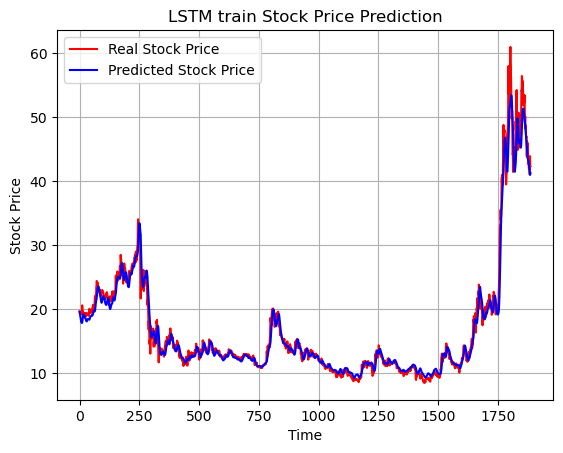

         date   open  close   high    low   volume   SMA_5  SMA_10     EMA_12  \
13  2014/1/21  35.80  36.00  36.95  35.50  3739251  36.106  37.822  38.035060   
14  2014/1/22  36.01  37.03  37.10  36.01  5416139  36.052  37.446  37.880435   
15  2014/1/23  37.25  36.58  37.81  36.45  4256500  36.194  37.154  37.680368   
16  2014/1/24  36.40  36.43  36.71  35.90  5170516  36.262  36.822  37.488004   
17  2014/1/27  36.38  35.90  36.38  35.60  4386187  36.388  36.517  37.243696   

       EMA_26      MACD  Signal_Line     RSI_14  
13  39.902306 -1.867246    -1.318264  14.694280  
14  39.689543 -1.809108    -1.416433  22.560430  
15  39.459206 -1.778838    -1.488914  23.463687  
16  39.234821 -1.746817    -1.540495  26.277372  
17  38.987797 -1.744101    -1.581216  26.141079  
Epoch 1/20, Loss: 0.0768, Val Loss: 0.0226
Epoch 2/20, Loss: 0.0335, Val Loss: 0.0239
Epoch 3/20, Loss: 0.0078, Val Loss: 0.0082
Epoch 4/20, Loss: 0.0047, Val Loss: 0.0054
Epoch 5/20, Loss: 0.0035, Val Loss: 0.005

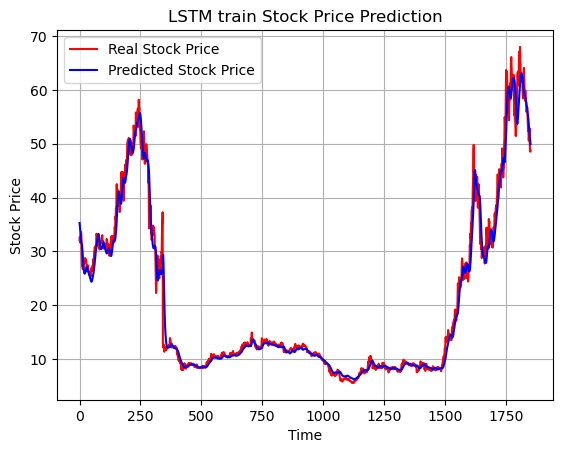

         date  open  close  high   low    volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  5.96   6.05  6.07  5.94  13642697  5.986   5.974  6.023386   
14  2014/1/22  6.05   6.08  6.11  6.02  13723047  6.008   5.983  6.032096   
15  2014/1/23  6.13   6.10  6.23  6.07  17712039  6.030   6.003  6.042543   
16  2014/1/24  6.10   6.11  6.15  6.06  14579987  6.060   6.018  6.052921   
17  2014/1/27  6.08   6.02  6.09  5.99  13092647  6.072   6.024  6.047856   

      EMA_26      MACD  Signal_Line     RSI_14  
13  6.098412 -0.075025    -0.073337  32.307692  
14  6.097048 -0.064952    -0.071660  35.294118  
15  6.097267 -0.054724    -0.068272  43.333333  
16  6.098210 -0.045289    -0.063676  56.250000  
17  6.092417 -0.044560    -0.059853  50.943396  
Epoch 1/20, Loss: 0.1871, Val Loss: 0.0396
Epoch 2/20, Loss: 0.0455, Val Loss: 0.2034
Epoch 3/20, Loss: 0.0349, Val Loss: 0.0948
Epoch 4/20, Loss: 0.0244, Val Loss: 0.0459
Epoch 5/20, Loss: 0.0114, Val Loss: 0.0105
Epoch 6/20, Loss: 0.0075, Va

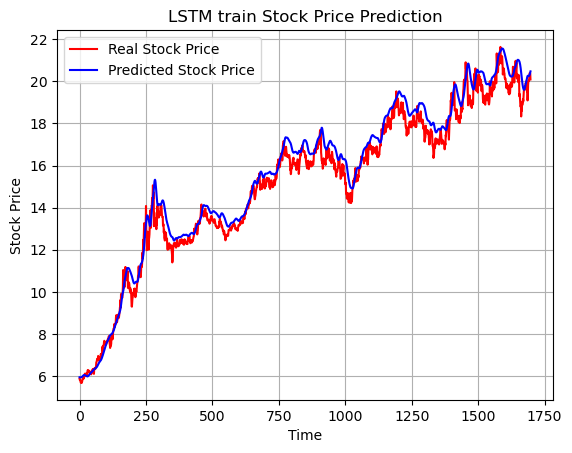

         date  open  close  high   low    volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  2.74   2.75  2.77  2.72  14647033  2.784   2.803  2.829773   
14  2014/1/22  2.76   2.83  2.84  2.75  25282411  2.782   2.802  2.829808   
15  2014/1/23  2.86   2.83  2.86  2.82  25150435  2.782   2.802  2.829838   
16  2014/1/24  2.81   2.84  2.87  2.81  29246996  2.796   2.806  2.831401   
17  2014/1/27  2.84   2.81  2.86  2.79  34008088  2.812   2.808  2.828109   

      EMA_26      MACD  Signal_Line     RSI_14  
13  2.908007 -0.078234    -0.063637  16.666667  
14  2.902229 -0.072420    -0.065394  28.571429  
15  2.896878 -0.067041    -0.065723  32.000000  
16  2.892665 -0.061264    -0.064831  45.945946  
17  2.886542 -0.058433    -0.063552  43.589744  
Epoch 1/20, Loss: 0.0283, Val Loss: 0.0070
Epoch 2/20, Loss: 0.0185, Val Loss: 0.0013
Epoch 3/20, Loss: 0.0085, Val Loss: 0.0055
Epoch 4/20, Loss: 0.0048, Val Loss: 0.0018
Epoch 5/20, Loss: 0.0030, Val Loss: 0.0017
Epoch 6/20, Loss: 0.0025, Va

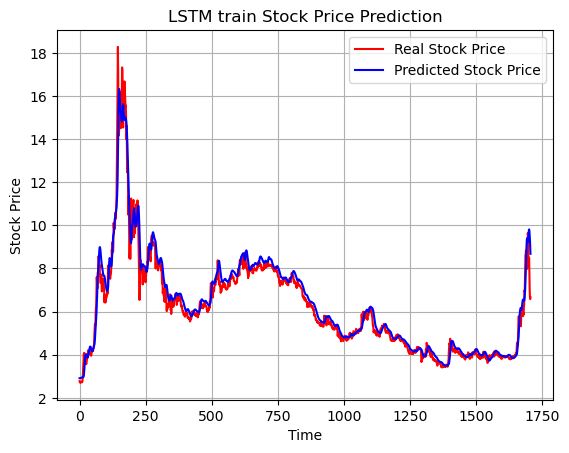

         date   open  close   high    low   volume   SMA_5  SMA_10     EMA_12  \
13  2014/1/21  18.36  18.32  18.53  18.20  2315118  18.166  18.037  18.278862   
14  2014/1/22  18.18  18.80  19.06  18.15  7894397  18.286  18.139  18.359037   
15  2014/1/23  18.50  18.42  18.69  18.01  8438782  18.312  18.217  18.368416   
16  2014/1/24  18.21  18.17  18.52  18.11  7499748  18.432  18.256  18.337890   
17  2014/1/27  18.12  18.12  18.45  17.88  6985045  18.366  18.262  18.304369   

       EMA_26      MACD  Signal_Line     RSI_14  
13  18.562082 -0.283220    -0.286792  39.651416  
14  18.579706 -0.220669    -0.273567  45.364892  
15  18.567876 -0.199460    -0.258746  43.478261  
16  18.538403 -0.200513    -0.247099  49.356223  
17  18.507410 -0.203042    -0.238288  46.444444  
Epoch 1/20, Loss: 0.0741, Val Loss: 0.0893
Epoch 2/20, Loss: 0.0350, Val Loss: 0.0216
Epoch 3/20, Loss: 0.0078, Val Loss: 0.0197
Epoch 4/20, Loss: 0.0047, Val Loss: 0.0095
Epoch 5/20, Loss: 0.0036, Val Loss: 0.007

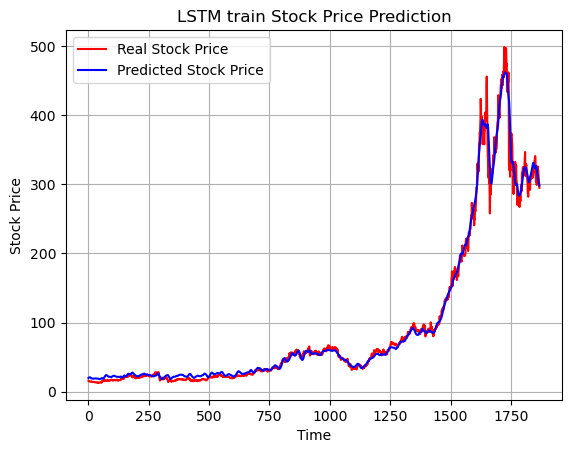

         date  open  close  high   low    volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  3.39   3.40  3.42  3.38  51800518  3.420   3.479  3.473673   
14  2014/1/22  3.40   3.43  3.43  3.39  78229837  3.414   3.465  3.466954   
15  2014/1/23  3.41   3.40  3.42  3.39  53203666  3.408   3.452  3.456654   
16  2014/1/24  3.40   3.40  3.41  3.39  49522632  3.406   3.439  3.447938   
17  2014/1/27  3.39   3.36  3.40  3.33  99385374  3.398   3.421  3.434409   

      EMA_26      MACD  Signal_Line     RSI_14  
13  3.516176 -0.042502    -0.025322  12.500000  
14  3.509792 -0.042838    -0.028825  22.222222  
15  3.501659 -0.045006    -0.032061  21.428571  
16  3.494129 -0.046191    -0.034887  22.222222  
17  3.484194 -0.049785    -0.037867  19.354839  
Epoch 1/20, Loss: 0.1031, Val Loss: 0.0580
Epoch 2/20, Loss: 0.0261, Val Loss: 0.0075
Epoch 3/20, Loss: 0.0175, Val Loss: 0.0037
Epoch 4/20, Loss: 0.0076, Val Loss: 0.0011
Epoch 5/20, Loss: 0.0055, Val Loss: 0.0005
Epoch 6/20, Loss: 0.0042, Va

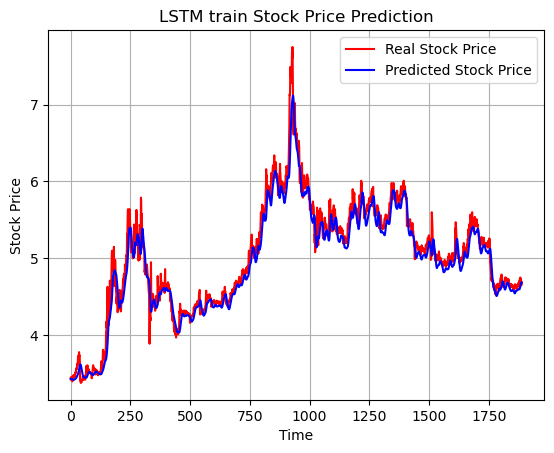

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  14.09  14.21  14.43  14.05   8492072  14.534  14.859   
14  2014/1/22  14.32  14.62  14.63  14.01  17324977  14.424  14.759   
15  2014/1/23  14.58  14.54  14.75  14.49  12608981  14.360  14.672   
16  2014/1/24  14.48  14.59  14.77  14.37  16400236  14.412  14.642   
17  2014/1/27  14.59  14.74  14.86  14.51  13298551  14.540  14.617   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  14.688240  14.758406 -0.070166     0.038070  42.492013  
14  14.677742  14.748154 -0.070412     0.016374  49.152542  
15  14.656551  14.732735 -0.076185    -0.002138  47.338936  
16  14.646312  14.722162 -0.075850    -0.016880  46.892655  
17  14.660726  14.723484 -0.062758    -0.026056  37.333333  
Epoch 1/20, Loss: 0.0265, Val Loss: 0.1795
Epoch 2/20, Loss: 0.0192, Val Loss: 0.0722
Epoch 3/20, Loss: 0.0052, Val Loss: 0.0320
Epoch 4/20, Loss: 0.0036, Val Loss: 0.0180
Epoch 5/20, Loss: 0.0027, Val Loss:

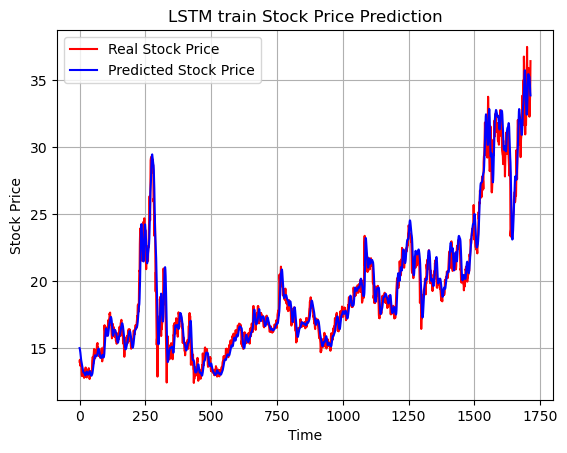

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  19.63  20.03  20.30  19.36   9928958  19.924  19.142   
14  2014/1/22  20.03  20.77  21.00  19.83  18758346  20.098  19.362   
15  2014/1/23  20.74  21.19  21.60  20.58  16244818  20.336  19.688   
16  2014/1/24  20.90  21.80  22.17  20.81  16528603  20.708  20.049   
17  2014/1/27  21.60  21.43  22.36  21.20  13677703  21.044  20.392   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  19.374054  19.211028  0.163026    -0.007018  58.666667  
14  19.588815  19.326508  0.262307     0.046847  64.503817  
15  19.835151  19.464544  0.370607     0.111599  74.803150  
16  20.137436  19.637541  0.499895     0.189258  78.750000  
17  20.336292  19.770316  0.565976     0.264602  75.255973  
Epoch 1/20, Loss: 0.0917, Val Loss: 0.0197
Epoch 2/20, Loss: 0.0385, Val Loss: 0.0077
Epoch 3/20, Loss: 0.0144, Val Loss: 0.0126
Epoch 4/20, Loss: 0.0089, Val Loss: 0.0049
Epoch 5/20, Loss: 0.0063, Val Loss:

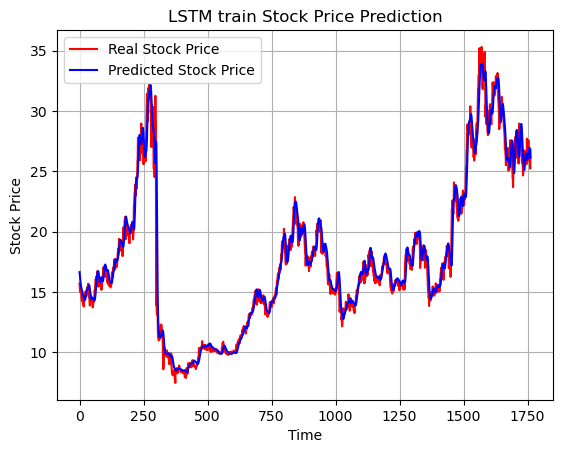

         date   open  close   high    low    volume   SMA_5  SMA_10  \
32  2014/2/24  70.05  72.65  72.80  69.91   5130727  72.430  71.953   
33  2014/2/25  72.70  72.80  77.76  72.00  10440556  72.036  72.592   
34  2014/2/26  72.83  69.99  73.77  67.50   6425508  71.670  72.286   
35  2014/2/27  69.90  67.72  70.53  67.50   4445610  70.802  71.866   
36  2014/2/28  67.60  70.25  70.79  65.03   4695139  70.682  71.533   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
32  71.071498  69.450415  1.621083     1.324050  46.470132  
33  71.337421  69.698532  1.638889     1.387018  44.277108  
34  71.130126  69.720122  1.410003     1.391615  36.850783  
35  70.605491  69.571965  1.033526     1.319997  41.031563  
36  70.550800  69.622190  0.928610     1.241720  46.382979  
Epoch 1/20, Loss: 0.0544, Val Loss: 0.0015
Epoch 2/20, Loss: 0.0107, Val Loss: 0.0028
Epoch 3/20, Loss: 0.0047, Val Loss: 0.0014
Epoch 4/20, Loss: 0.0031, Val Loss: 0.0010
Epoch 5/20, Loss: 0.0022, Val Loss:

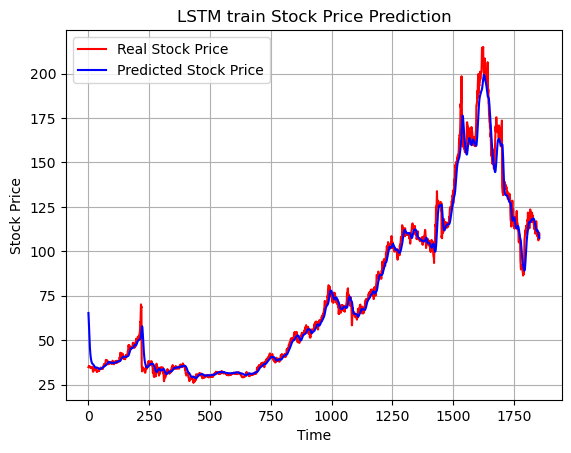

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  19.90  19.91  19.97  19.44   8183763  19.884  18.828   
14  2014/1/22  19.84  20.15  20.30  19.71  14471183  20.004  19.012   
15  2014/1/23  20.15  19.92  20.32  19.86  11628395  19.944  19.206   
16  2014/1/24  19.96  20.82  20.90  19.78  14987895  20.120  19.548   
17  2014/1/27  20.62  20.78  21.29  20.41  15899623  20.316  19.886   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  19.163771  19.037760  0.126011    -0.090093  55.369128  
14  19.315498  19.120148  0.195350    -0.033004  57.096774  
15  19.408499  19.179396  0.229102     0.019417  59.898477  
16  19.625653  19.300922  0.324730     0.080480  74.000000  
17  19.803244  19.410484  0.392761     0.142936  72.927242  
Epoch 1/20, Loss: 0.0538, Val Loss: 0.0259
Epoch 2/20, Loss: 0.0260, Val Loss: 0.0061
Epoch 3/20, Loss: 0.0095, Val Loss: 0.0082
Epoch 4/20, Loss: 0.0069, Val Loss: 0.0025
Epoch 5/20, Loss: 0.0056, Val Loss:

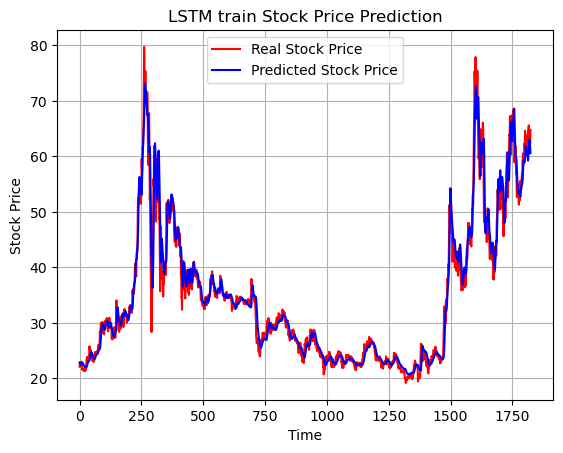

         date   open  close   high    low   volume   SMA_5  SMA_10     EMA_12  \
13  2014/1/21  36.49  36.56  36.89  36.11  2862189  37.430  37.646  37.628681   
14  2014/1/22  36.65  37.35  37.37  36.26  3589380  37.116  37.502  37.585807   
15  2014/1/23  37.30  36.12  37.30  36.02  6868811  36.728  37.224  37.360299   
16  2014/1/24  36.00  36.51  36.85  35.80  9217791  36.602  37.101  37.229483   
17  2014/1/27  36.40  36.08  36.49  35.30  5225640  36.524  37.002  37.052640   

       EMA_26      MACD  Signal_Line     RSI_14  
13  38.161215 -0.532534    -0.345088  37.139918  
14  38.101125 -0.515318    -0.379134  41.864891  
15  37.954375 -0.594077    -0.422123  38.327526  
16  37.847384 -0.617901    -0.461278  45.359848  
17  37.716467 -0.663827    -0.501788  36.213992  
Epoch 1/20, Loss: 0.1328, Val Loss: 0.1392
Epoch 2/20, Loss: 0.0431, Val Loss: 0.0506
Epoch 3/20, Loss: 0.0175, Val Loss: 0.0093
Epoch 4/20, Loss: 0.0077, Val Loss: 0.0044
Epoch 5/20, Loss: 0.0066, Val Loss: 0.005

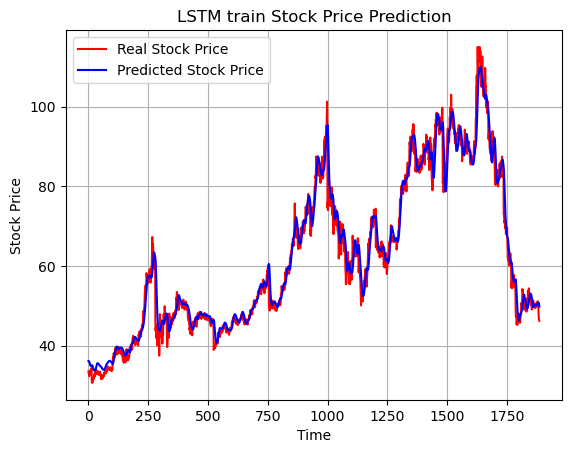

          date   open  close   high    low    volume   SMA_5  SMA_10  \
272  2015/2/11  16.23  16.23  16.23  16.23   1225437  13.532  10.963   
273  2015/2/12  17.85  17.85  17.85  17.85    949967  14.886  12.061   
274  2015/2/13  19.64  19.64  19.64  19.64    996753  16.376  13.269   
275  2015/2/16  21.60  21.60  21.60  21.60   1478079  18.014  14.597   
276  2015/2/17  23.76  23.76  23.76  22.58  30973151  19.816  16.058   

        EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
272  11.323505   9.419219  1.904286     1.001198  57.906216  
273  12.327581  10.043721  2.283860     1.257731  50.311850  
274  13.452569  10.754557  2.698012     1.545787  56.497175  
275  14.706020  11.557923  3.148097     1.866249  40.320733  
276  16.098940  12.461780  3.637159     2.220431  43.093270  
Epoch 1/20, Loss: 0.0799, Val Loss: 0.1253
Epoch 2/20, Loss: 0.0364, Val Loss: 0.2026
Epoch 3/20, Loss: 0.0201, Val Loss: 0.0265
Epoch 4/20, Loss: 0.0064, Val Loss: 0.0084
Epoch 5/20, Loss: 0.005

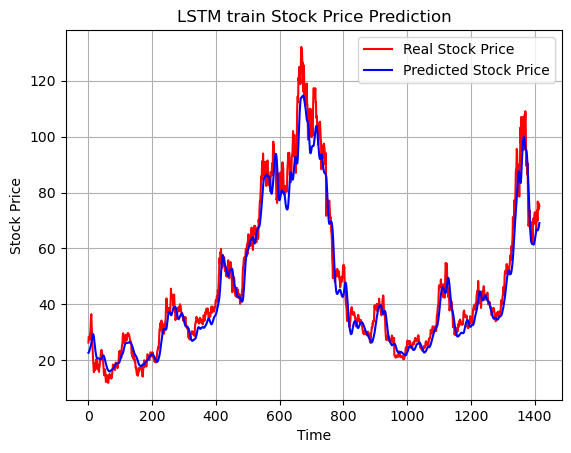

         date  open  close  high   low    volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  2.98   3.01  3.02  2.97  39492687  3.004   3.014  3.041188   
14  2014/1/22  3.01   3.05  3.06  2.99  74197345  3.008   3.014  3.042544   
15  2014/1/23  3.05   3.02  3.05  3.01  56090980  3.010   3.014  3.039075   
16  2014/1/24  3.01   3.03  3.05  2.99  77247221  3.018   3.017  3.037679   
17  2014/1/27  3.01   2.99  3.01  2.98  62433504  3.020   3.015  3.030344   

      EMA_26      MACD  Signal_Line     RSI_14  
13  3.101293 -0.060105    -0.051628  21.052632  
14  3.097493 -0.054949    -0.052292  28.571429  
15  3.091753 -0.052677    -0.052369  30.769231  
16  3.087179 -0.049499    -0.051795  41.935484  
17  3.079980 -0.049636    -0.051363  35.294118  
Epoch 1/20, Loss: 0.0817, Val Loss: 0.1181
Epoch 2/20, Loss: 0.0305, Val Loss: 0.0281
Epoch 3/20, Loss: 0.0181, Val Loss: 0.0192
Epoch 4/20, Loss: 0.0084, Val Loss: 0.0045
Epoch 5/20, Loss: 0.0059, Val Loss: 0.0040
Epoch 6/20, Loss: 0.0047, Va

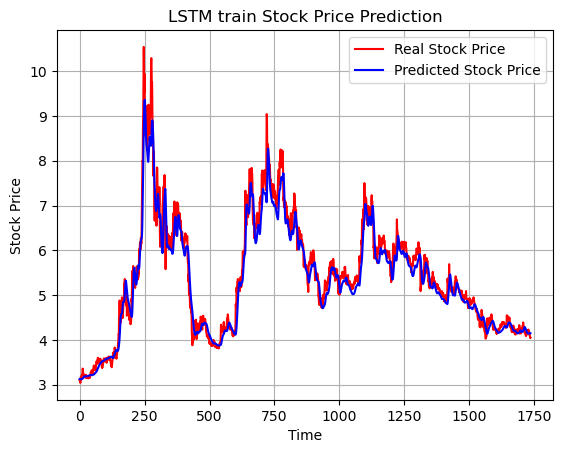

         date   open  close   high    low   volume   SMA_5  SMA_10     EMA_12  \
16  2014/1/24  17.25  17.56  18.17  17.25  6360173  16.948  16.486  16.436371   
17  2014/1/27  17.28  16.38  17.28  16.33  6808234  16.938  16.632  16.427698   
18  2014/1/28  16.40  16.00  16.55  15.90  3975906  16.846  16.698  16.361899   
19  2014/1/29  16.04  16.25  16.33  15.93  2532322  16.726  16.665  16.344683   
20  2014/1/30  16.30  15.40  16.30  15.31  3808247  16.318  16.529  16.199347   

       EMA_26      MACD  Signal_Line     RSI_14  
16  15.838840  0.597530     0.377335  53.162393  
17  15.878926  0.548772     0.411623  50.000000  
18  15.887895  0.474004     0.424099  47.411003  
19  15.914717  0.429966     0.425272  45.996860  
20  15.876590  0.322757     0.404769  49.707602  
Epoch 1/20, Loss: 0.0767, Val Loss: 0.0237
Epoch 2/20, Loss: 0.0303, Val Loss: 0.0468
Epoch 3/20, Loss: 0.0089, Val Loss: 0.0337
Epoch 4/20, Loss: 0.0059, Val Loss: 0.0123
Epoch 5/20, Loss: 0.0048, Val Loss: 0.012

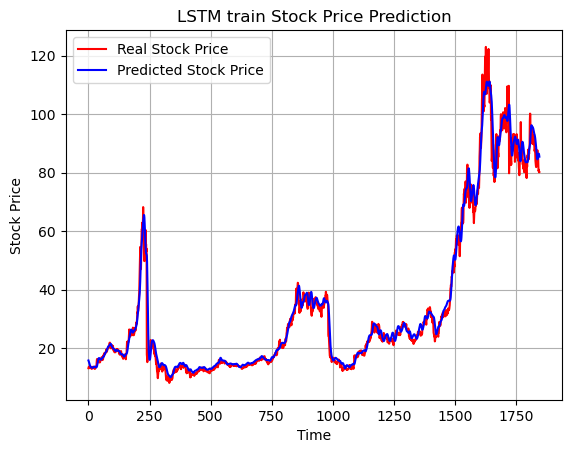

         date    open   close    high     low   volume    SMA_5   SMA_10  \
13  2014/1/21  126.00  126.99  128.71  125.35  3540462  122.966  121.404   
14  2014/1/22  126.98  134.17  134.81  126.30  7366781  126.048  122.881   
15  2014/1/23  134.18  134.09  135.40  131.76  4025848  128.468  124.356   
16  2014/1/24  133.50  135.50  135.69  132.51  3578070  131.508  125.979   
17  2014/1/27  134.89  140.75  143.78  134.66  8351084  134.300  128.065   

        EMA_12      EMA_26      MACD  Signal_Line     RSI_14  
13  122.877332  123.391062 -0.513730    -1.122010  52.204278  
14  124.614666  124.189502  0.425164    -0.812575  63.609172  
15  126.072409  124.922872  1.149537    -0.420153  67.944622  
16  127.522808  125.706363  1.816445     0.027167  78.047854  
17  129.557760  126.820707  2.737054     0.569144  82.139446  
Epoch 1/20, Loss: 0.1055, Val Loss: 0.0316
Epoch 2/20, Loss: 0.0389, Val Loss: 0.0055
Epoch 3/20, Loss: 0.0083, Val Loss: 0.0110
Epoch 4/20, Loss: 0.0053, Val Loss: 

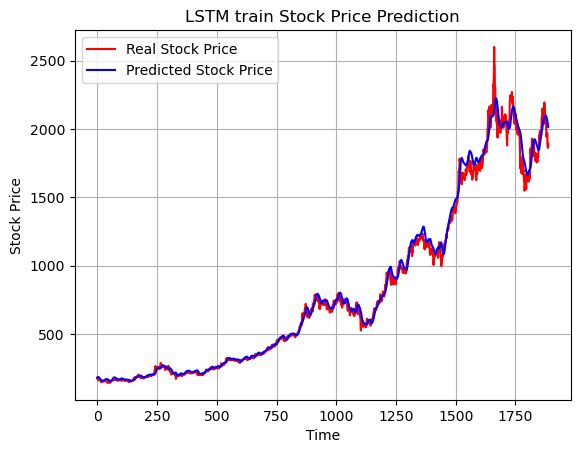

         date  open  close  high   low     volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  2.37   2.37  2.38  2.36   52002070  2.372   2.392  2.396987   
14  2014/1/22  2.37   2.39  2.40  2.37  118387537  2.372   2.389  2.395912   
15  2014/1/23  2.38   2.36  2.38  2.36   80176963  2.368   2.384  2.390387   
16  2014/1/24  2.36   2.37  2.38  2.36   66719628  2.370   2.380  2.387251   
17  2014/1/27  2.36   2.36  2.37  2.35   48672063  2.370   2.375  2.383058   

      EMA_26      MACD  Signal_Line     RSI_14  
13  2.423122 -0.026135    -0.018891   8.333333  
14  2.420668 -0.024756    -0.020064  21.428571  
15  2.416174 -0.025787    -0.021209  18.750000  
16  2.412754 -0.025503    -0.022068  26.666667  
17  2.408846 -0.025788    -0.022812  26.666667  
Epoch 1/20, Loss: 0.1434, Val Loss: 0.0998
Epoch 2/20, Loss: 0.0309, Val Loss: 0.0136
Epoch 3/20, Loss: 0.0215, Val Loss: 0.0208
Epoch 4/20, Loss: 0.0146, Val Loss: 0.0048
Epoch 5/20, Loss: 0.0074, Val Loss: 0.0010
Epoch 6/20, Loss: 0.00

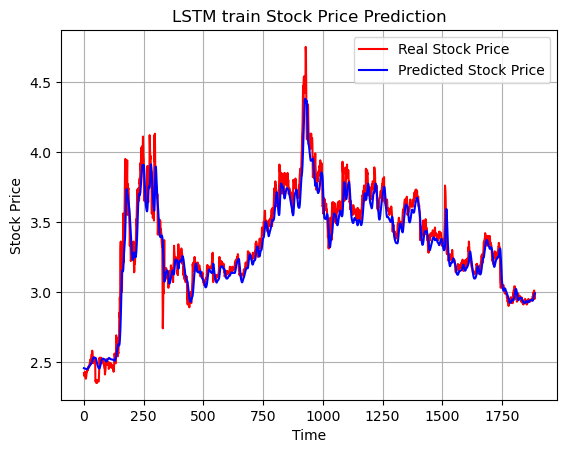

         date   open  close   high    low   volume   SMA_5  SMA_10     EMA_12  \
13  2014/1/21  83.21  84.93  85.60  83.21   674333  89.190  92.845  92.294983   
14  2014/1/22  84.98  86.65  86.75  83.60  1335695  87.890  91.742  91.426524   
15  2014/1/23  86.71  88.42  90.33  86.70  1279510  86.902  90.724  90.963982   
16  2014/1/24  88.01  90.75  91.90  88.01  1107470  87.088  90.039  90.931062   
17  2014/1/27  90.55  88.46  90.55  87.78   800773  87.842  89.449  90.550898   

       EMA_26      MACD  Signal_Line     RSI_14  
13  95.340870 -3.045887    -1.646842  11.910927  
14  94.697102 -3.270578    -1.971589  19.115549  
15  94.232131 -3.268149    -2.230901  25.710480  
16  93.974196 -3.043134    -2.393347  35.319704  
17  93.565737 -3.014838    -2.517646  29.527721  
Epoch 1/20, Loss: 0.0812, Val Loss: 0.0562
Epoch 2/20, Loss: 0.0230, Val Loss: 0.0203
Epoch 3/20, Loss: 0.0064, Val Loss: 0.0062
Epoch 4/20, Loss: 0.0043, Val Loss: 0.0091
Epoch 5/20, Loss: 0.0036, Val Loss: 0.002

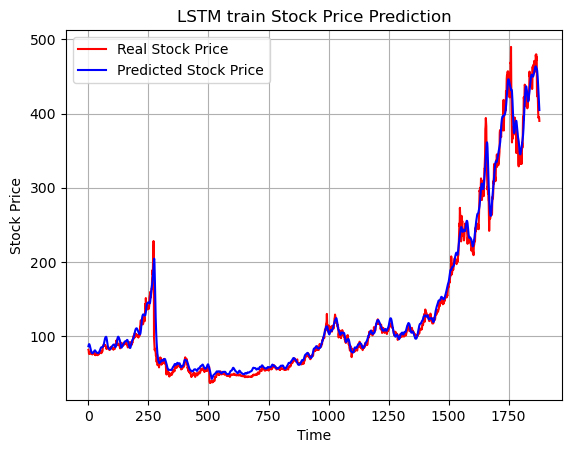

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  40.80  41.35  41.92  40.80  26650072  40.774  40.348   
14  2014/1/22  41.31  41.81  42.14  41.16  33532100  41.192  40.466   
15  2014/1/23  41.60  41.00  41.76  40.80  31827839  41.148  40.569   
16  2014/1/24  40.62  40.53  41.39  40.50  30177383  41.082  40.665   
17  2014/1/27  39.98  39.00  39.98  38.68  59556355  40.738  40.620   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  40.619743  40.736713 -0.116970    -0.234108  50.392465  
14  40.802859  40.816215 -0.013356    -0.189958  53.733529  
15  40.833188  40.829829  0.003359    -0.151294  55.354449  
16  40.786544  40.807619 -0.021075    -0.125251  51.690141  
17  40.511691  40.673722 -0.162031    -0.132607  43.534994  
Epoch 1/20, Loss: 0.1849, Val Loss: 0.1426
Epoch 2/20, Loss: 0.0621, Val Loss: 0.0363
Epoch 3/20, Loss: 0.0255, Val Loss: 0.0013
Epoch 4/20, Loss: 0.0128, Val Loss: 0.0015
Epoch 5/20, Loss: 0.0105, Val Loss:

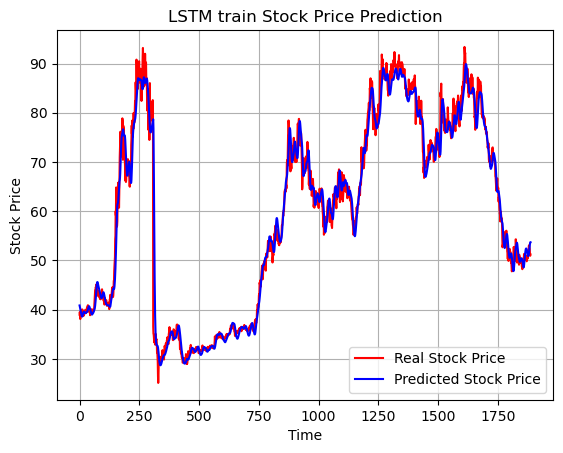

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  14.23  14.30  14.50  14.23   9255832  14.356  14.349   
14  2014/1/22  14.33  14.64  14.65  14.21  11506969  14.432  14.344   
15  2014/1/23  14.64  14.51  14.64  14.43  12869103  14.454  14.364   
16  2014/1/24  14.40  14.35  14.55  14.30  12283040  14.404  14.369   
17  2014/1/27  14.21  13.76  14.22  13.71  16579385  14.312  14.328   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  14.436515  14.603995 -0.167480    -0.144825  34.285714  
14  14.467820  14.606662 -0.138842    -0.143629  43.442623  
15  14.474309  14.599502 -0.125193    -0.139941  48.623853  
16  14.455185  14.581020 -0.125835    -0.137120  39.906103  
17  14.348233  14.520204 -0.171971    -0.144090  31.716418  
Epoch 1/20, Loss: 0.1350, Val Loss: 0.0197
Epoch 2/20, Loss: 0.0339, Val Loss: 0.0105
Epoch 3/20, Loss: 0.0226, Val Loss: 0.0045
Epoch 4/20, Loss: 0.0106, Val Loss: 0.0042
Epoch 5/20, Loss: 0.0075, Val Loss:

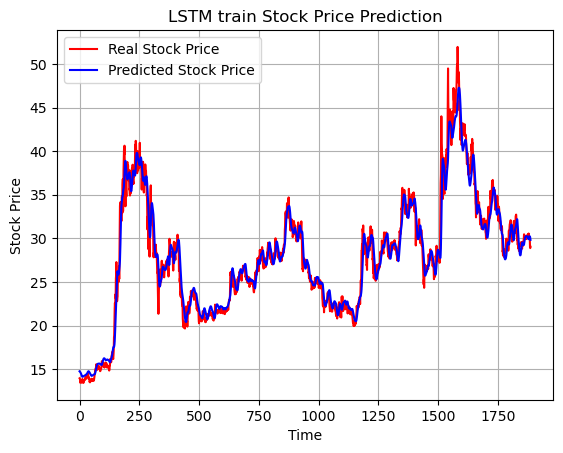

         date  open  close  high   low    volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  5.74   5.77  5.81  5.73   9666536  5.780   5.827  5.889798   
14  2014/1/22  5.80   6.02  6.04  5.75  23516102  5.828   5.828  5.909829   
15  2014/1/23  6.01   5.96  6.04  5.93  13156831  5.848   5.829  5.917548   
16  2014/1/24  5.92   5.98  6.08  5.91  13652679  5.892   5.850  5.927156   
17  2014/1/27  5.96   5.96  6.00  5.90  10072641  5.938   5.865  5.932209   

      EMA_26      MACD  Signal_Line     RSI_14  
13  6.051490 -0.161693    -0.133444  18.556701  
14  6.049158 -0.139329    -0.134621  35.245902  
15  6.042554 -0.125006    -0.132698  36.134454  
16  6.037920 -0.110764    -0.128311  45.454545  
17  6.032148 -0.099939    -0.122637  46.391753  
Epoch 1/20, Loss: 0.0443, Val Loss: 0.0063
Epoch 2/20, Loss: 0.0146, Val Loss: 0.0150
Epoch 3/20, Loss: 0.0045, Val Loss: 0.0018
Epoch 4/20, Loss: 0.0025, Val Loss: 0.0018
Epoch 5/20, Loss: 0.0017, Val Loss: 0.0008
Epoch 6/20, Loss: 0.0014, Va

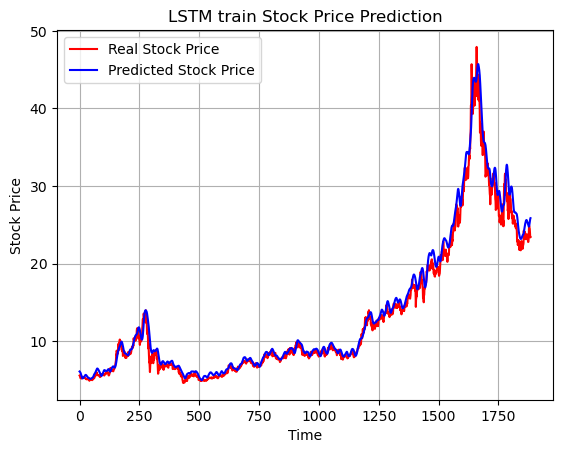

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  12.53  12.68  12.75  12.52  13073519  12.818  12.973   
14  2014/1/22  12.70  13.09  13.17  12.67  26193844  12.796  12.942   
15  2014/1/23  13.11  13.07  13.24  13.03  20695865  12.790  12.943   
16  2014/1/24  13.05  13.18  13.34  12.99  19463658  12.900  12.955   
17  2014/1/27  13.07  13.07  13.22  12.94  15980804  13.018  12.961   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  13.005539  13.291587 -0.286047    -0.214518  28.089888  
14  13.018533  13.276654 -0.258121    -0.223239  37.662338  
15  13.026451  13.261347 -0.234895    -0.225570  42.962963  
16  13.050074  13.255321 -0.205247    -0.221505  52.916667  
17  13.053140  13.241593 -0.188454    -0.214895  48.547718  
Epoch 1/20, Loss: 0.1651, Val Loss: 0.1955
Epoch 2/20, Loss: 0.0439, Val Loss: 0.0527
Epoch 3/20, Loss: 0.0242, Val Loss: 0.0267
Epoch 4/20, Loss: 0.0087, Val Loss: 0.0076
Epoch 5/20, Loss: 0.0064, Val Loss:

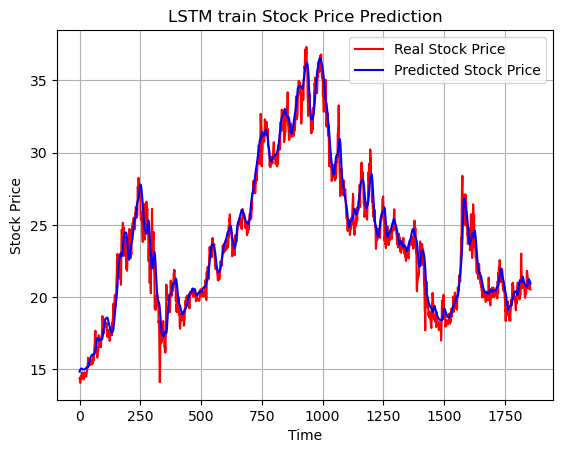

         date  open  close  high   low     volume  SMA_5  SMA_10    EMA_12  \
27  2014/2/17  4.38   4.68  4.77  4.38  156329185  4.396   4.312  4.393146   
28  2014/2/18  4.69   4.95  5.14  4.63  182151767  4.528   4.352  4.478816   
29  2014/2/19  4.85   4.78  4.91  4.64  104066597  4.602   4.409  4.525152   
30  2014/2/20  4.76   4.75  4.96  4.71   88475824  4.700   4.481  4.559744   
31  2014/2/21  4.69   4.48  4.70  4.43   87199849  4.728   4.519  4.547476   

      EMA_26      MACD  Signal_Line     RSI_14  
27  4.432209 -0.039063    -0.057502  39.622642  
28  4.470564  0.008252    -0.044351  36.521739  
29  4.493485  0.031667    -0.029147  47.368421  
30  4.512486  0.047258    -0.013866  43.820225  
31  4.510080  0.037396    -0.003614  50.632911  
Epoch 1/20, Loss: 0.0160, Val Loss: 0.2839
Epoch 2/20, Loss: 0.0118, Val Loss: 0.2053
Epoch 3/20, Loss: 0.0052, Val Loss: 0.1003
Epoch 4/20, Loss: 0.0021, Val Loss: 0.1039
Epoch 5/20, Loss: 0.0015, Val Loss: 0.0568
Epoch 6/20, Loss: 0.00

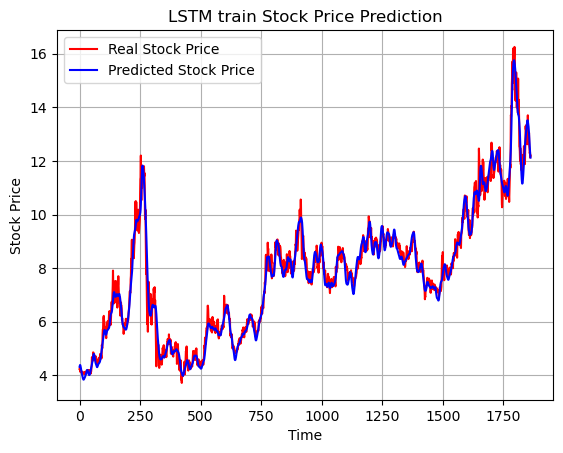

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  14.09  14.15  14.19  14.08   4766322  14.300  14.418   
14  2014/1/22  14.18  14.39  14.40  14.10   8436680  14.272  14.401   
15  2014/1/23  14.40  14.25  14.42  14.25   6329619  14.222  14.382   
16  2014/1/24  14.25  14.37  14.49  14.21   8612848  14.250  14.370   
17  2014/1/27  14.31  14.09  14.33  14.00  12875083  14.250  14.323   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  14.541040  14.902056 -0.361016    -0.286908  12.626263  
14  14.517803  14.864126 -0.346323    -0.298791  22.072072  
15  14.476602  14.818635 -0.342032    -0.307439  23.333333  
16  14.460202  14.785403 -0.325201    -0.310992  36.094675  
17  14.403248  14.733891 -0.330643    -0.314922  31.282051  
Epoch 1/20, Loss: 0.0209, Val Loss: 0.2289
Epoch 2/20, Loss: 0.0143, Val Loss: 0.2071
Epoch 3/20, Loss: 0.0080, Val Loss: 0.0547
Epoch 4/20, Loss: 0.0037, Val Loss: 0.0950
Epoch 5/20, Loss: 0.0029, Val Loss:

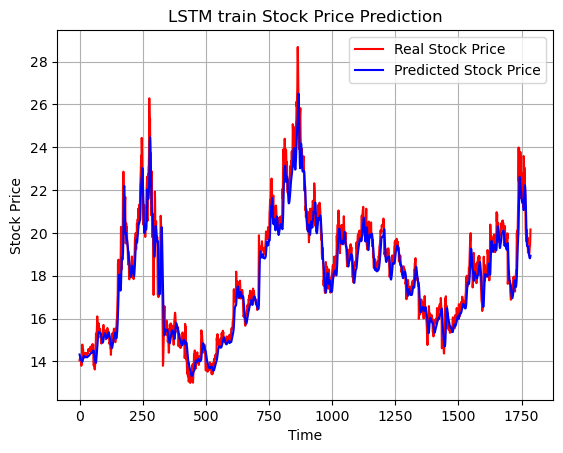

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  17.08  17.15  17.38  17.03  15179434  17.122  17.114   
14  2014/1/22  17.15  17.47  17.50  17.05  20176935  17.194  17.140   
15  2014/1/23  17.43  17.10  17.43  17.02  25796809  17.156  17.146   
16  2014/1/24  17.00  17.00  17.22  16.99  22424119  17.152  17.141   
17  2014/1/27  17.00  16.45  17.00  16.40  34119629  17.034  17.085   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  17.246487  17.510668 -0.264181    -0.244623  27.522936  
14  17.280874  17.507656 -0.226782    -0.241055  36.800000  
15  17.253047  17.477459 -0.224412    -0.237726  37.246964  
16  17.214117  17.442092 -0.227975    -0.235776  44.230769  
17  17.096560  17.368603 -0.272043    -0.243029  36.363636  
Epoch 1/20, Loss: 0.1284, Val Loss: 0.1656
Epoch 2/20, Loss: 0.0376, Val Loss: 0.0403
Epoch 3/20, Loss: 0.0262, Val Loss: 0.0322
Epoch 4/20, Loss: 0.0124, Val Loss: 0.0059
Epoch 5/20, Loss: 0.0079, Val Loss:

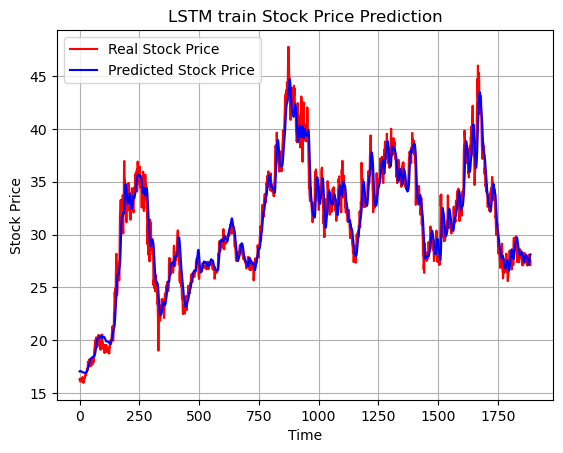

         date   open  close   high   low    volume   SMA_5  SMA_10     EMA_12  \
17  2014/1/27  10.20   9.82  10.22  9.66  45693829  10.086  10.441  10.371972   
18  2014/1/28   9.82   9.55   9.86  9.46  19795111   9.958  10.338  10.245515   
19  2014/1/29   9.56   9.38   9.59  9.25  31348388   9.826  10.175  10.112359   
20  2014/1/30   9.50   9.47   9.77  9.42  33760530   9.692  10.024  10.013534   
21   2014/2/7   9.45   9.46   9.46  9.24  28790825   9.536   9.874   9.928375   

       EMA_26      MACD  Signal_Line     RSI_14  
17  10.540790 -0.168818    -0.073989  38.871473  
18  10.467398 -0.221883    -0.103568  37.349398  
19  10.386850 -0.274492    -0.137753  37.764350  
20  10.318935 -0.305401    -0.171282  46.366782  
21  10.255311 -0.326935    -0.202413  52.573529  
Epoch 1/20, Loss: 0.0253, Val Loss: 0.2096
Epoch 2/20, Loss: 0.0135, Val Loss: 0.0065
Epoch 3/20, Loss: 0.0038, Val Loss: 0.0094
Epoch 4/20, Loss: 0.0025, Val Loss: 0.0058
Epoch 5/20, Loss: 0.0021, Val Loss: 0.009

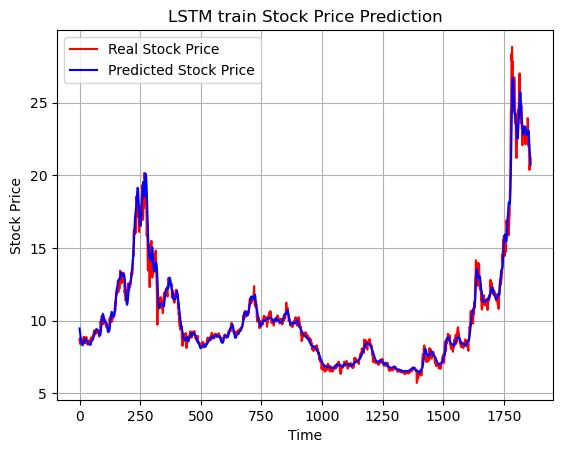

         date  open  close  high   low   volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  8.92   9.08  9.14  8.76  4970337  9.134   9.048  9.007826   
14  2014/1/22  9.08   8.97  9.13  8.90  6140527  9.084   9.036  9.002007   
15  2014/1/23  8.96   8.99  9.09  8.75  8929173  9.036   9.026  9.000160   
16  2014/1/24  8.92   8.99  9.03  8.74  7471320  8.994   9.024  8.998597   
17  2014/1/27  8.94   9.20  9.26  8.84  7621598  9.046   9.072  9.029582   

      EMA_26      MACD  Signal_Line     RSI_14  
13  8.937272  0.070554     0.049016  55.458515  
14  8.939696  0.062311     0.051675  52.916667  
15  8.943423  0.056737     0.052687  58.636364  
16  8.946873  0.051724     0.052495  54.726368  
17  8.965623  0.063959     0.054788  62.980769  
Epoch 1/20, Loss: 0.0436, Val Loss: 0.1599
Epoch 2/20, Loss: 0.0210, Val Loss: 0.0470
Epoch 3/20, Loss: 0.0052, Val Loss: 0.0185
Epoch 4/20, Loss: 0.0038, Val Loss: 0.0334
Epoch 5/20, Loss: 0.0029, Val Loss: 0.0092
Epoch 6/20, Loss: 0.0025, Val Loss

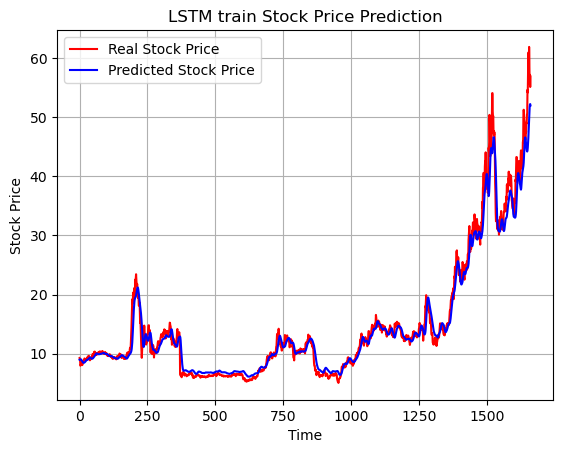

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  18.50  18.57  19.00  18.34  11414377  18.730  18.668   
14  2014/1/22  18.61  19.63  19.70  18.40  13351730  18.928  18.734   
15  2014/1/23  19.60  19.56  19.75  19.22  10891394  19.006  18.825   
16  2014/1/24  19.41  19.60  20.07  19.40   8256536  19.168  18.917   
17  2014/1/27  19.46  19.58  19.96  19.19   6593127  19.388  19.047   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  18.896272  19.340798 -0.444526    -0.398066  28.039702  
14  19.009154  19.362220 -0.353067    -0.389066  43.025540  
15  19.093899  19.376871 -0.282971    -0.367847  46.995708  
16  19.171761  19.393399 -0.221638    -0.338605  57.772021  
17  19.234567  19.407221 -0.172654    -0.305415  56.117021  
Epoch 1/20, Loss: 0.0491, Val Loss: 0.0769
Epoch 2/20, Loss: 0.0153, Val Loss: 0.0048
Epoch 3/20, Loss: 0.0041, Val Loss: 0.0032
Epoch 4/20, Loss: 0.0027, Val Loss: 0.0123
Epoch 5/20, Loss: 0.0022, Val Loss:

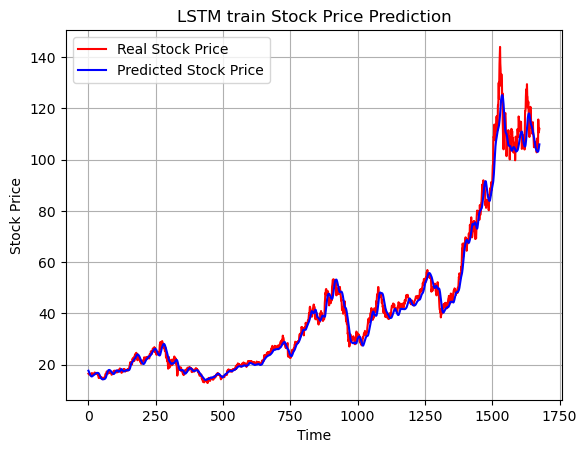

          date   open  close   high    low    volume   SMA_5  SMA_10  \
821  2017/5/17  23.84  23.84  23.84  23.84    164176  19.880  16.111   
822  2017/5/18  26.22  26.22  26.22  26.22    152672  21.868  17.722   
823  2017/5/19  28.84  24.29  28.84  24.06  24309815  23.144  19.039   
824  2017/5/22  22.90  21.86  23.32  21.86  12357647  23.576  20.002   
825  2017/5/23  20.71  22.18  22.47  20.63  13966429  23.678  20.875   

        EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
821  16.640778  13.847925  2.792853     1.467903  69.835190  
822  18.114504  14.764375  3.350130     1.844349  69.049805  
823  19.064581  15.469976  3.594604     2.194400  57.922362  
824  19.494645  15.943312  3.551334     2.465786  56.452703  
825  19.907777  16.405288  3.502488     2.673127  58.665886  
Epoch 1/20, Loss: 0.0629, Val Loss: 0.3681
Epoch 2/20, Loss: 0.0368, Val Loss: 0.2902
Epoch 3/20, Loss: 0.0179, Val Loss: 0.2010
Epoch 4/20, Loss: 0.0083, Val Loss: 0.1133
Epoch 5/20, Loss: 0.012

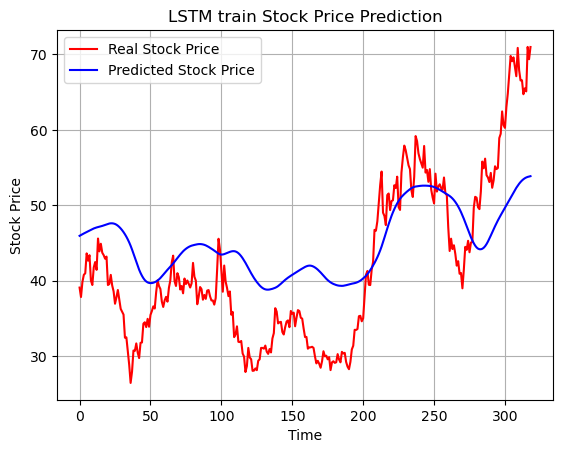

         date  open  close  high   low    volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  9.22   9.29  9.37  9.22  39795626  9.390   9.560  9.544583   
14  2014/1/22  9.32   9.56  9.63  9.29  75891856  9.376   9.547  9.546955   
15  2014/1/23  9.54   9.41  9.55  9.38  55814379  9.356   9.515  9.525885   
16  2014/1/24  9.37   9.39  9.48  9.32  70026283  9.372   9.479  9.504979   
17  2014/1/27  9.32   9.22  9.36  9.20  69871638  9.374   9.429  9.461136   

      EMA_26      MACD  Signal_Line     RSI_14  
13  9.703042 -0.158460    -0.103731  21.008403  
14  9.692447 -0.145492    -0.112083  35.616438  
15  9.671525 -0.145640    -0.118794  38.235294  
16  9.650671 -0.145692    -0.124174  39.694656  
17  9.618769 -0.157633    -0.130866  36.111111  
Epoch 1/20, Loss: 0.1325, Val Loss: 0.0131
Epoch 2/20, Loss: 0.0270, Val Loss: 0.0236
Epoch 3/20, Loss: 0.0209, Val Loss: 0.0192
Epoch 4/20, Loss: 0.0165, Val Loss: 0.0065
Epoch 5/20, Loss: 0.0086, Val Loss: 0.0035
Epoch 6/20, Loss: 0.0061, Va

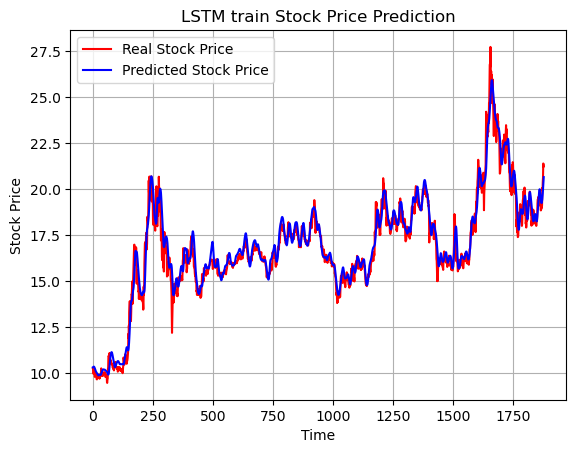

           date    open   close    high     low   volume   SMA_5  SMA_10  \
1067  2018/5/21   73.33   73.33   73.33   73.33   176218  61.152  49.562   
1068  2018/5/22   80.66   80.66   80.66   80.66   259098  67.268  54.518   
1069  2018/5/23   88.73   88.73   88.73   88.73   268867  73.996  59.970   
1070  2018/5/24   97.60   97.60   97.60   97.60   590152  81.396  65.967   
1071  2018/5/25  107.36  107.36  107.36  107.36  2535836  89.536  72.564   

         EMA_12     EMA_26       MACD  Signal_Line     RSI_14  
1067  51.189982  42.599112   8.590870     4.515927  16.842502  
1068  55.723831  45.418437  10.305394     5.673820  17.345751  
1069  60.801703  48.626701  12.175002     6.974056  22.650800  
1070  66.462979  52.254353  14.208627     8.420970  26.739215  
1071  72.754829  56.336253  16.418576    10.020492  25.239499  
Epoch 1/20, Loss: 0.2121, Val Loss: 0.1157
Epoch 2/20, Loss: 0.1743, Val Loss: 0.0882
Epoch 3/20, Loss: 0.1343, Val Loss: 0.0612
Epoch 4/20, Loss: 0.0938, Val 

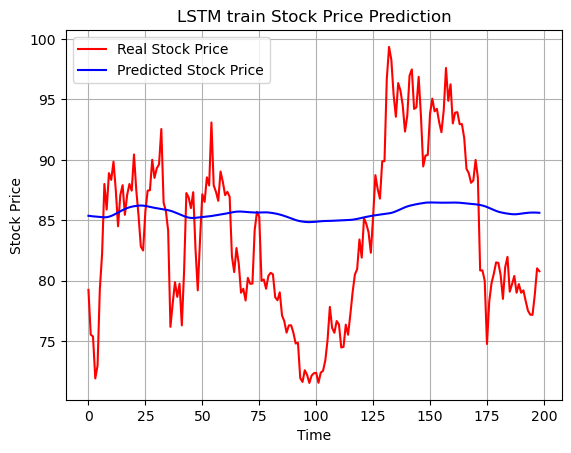

          date    open   close    high     low  volume   SMA_5  SMA_10  \
652  2016/8/31   78.96   78.96   78.96   78.96   28064  65.848  53.369   
653   2016/9/1   86.86   86.86   86.86   86.86   12812  72.434  58.706   
654   2016/9/2   95.55   95.55   95.55   95.55   69312  79.680  64.577   
655   2016/9/5  105.11  105.11  105.11  105.11   69519  87.652  71.036   
656   2016/9/6  115.62  115.62  115.62  115.62   54608  96.420  78.141   

        EMA_12     EMA_26       MACD  Signal_Line     RSI_14  
652  55.121678  45.871619   9.250058     4.862532  62.248308  
653  60.004496  48.907796  11.096701     6.109366  50.792665  
654  65.473035  52.362774  13.110262     7.509545  53.029479  
655  71.571030  56.269976  15.301054     9.067847  50.820019  
656  78.347795  60.666274  17.681521    10.790581  43.855289  
Epoch 1/20, Loss: 0.0154, Val Loss: 0.2243
Epoch 2/20, Loss: 0.0107, Val Loss: 0.1947
Epoch 3/20, Loss: 0.0106, Val Loss: 0.2120
Epoch 4/20, Loss: 0.0096, Val Loss: 0.2108
Epoch

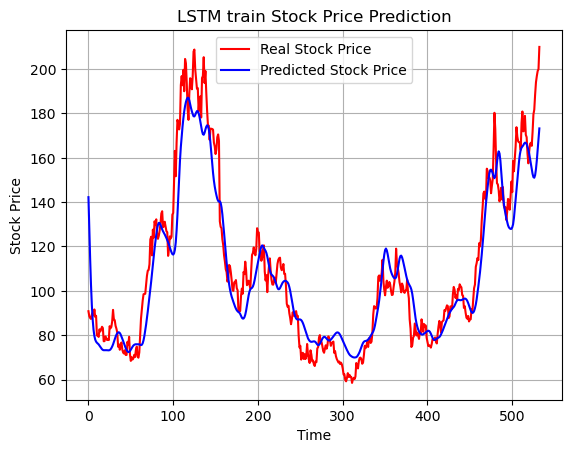

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  36.75  36.50  37.39  36.18   9185804  37.746  38.144   
14  2014/1/22  36.61  37.50  37.61  36.25  18505463  37.448  37.994   
15  2014/1/23  39.09  38.78  40.08  38.50  29893288  37.422  38.121   
16  2014/1/24  38.78  38.54  38.79  38.16  12540136  37.614  38.074   
17  2014/1/27  38.37  37.32  38.37  36.80  16159775  37.728  37.961   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  37.676891  37.528938  0.147952     0.291033  47.565119  
14  37.649677  37.526795  0.122882     0.257402  52.899288  
15  37.823573  37.619625  0.203948     0.246712  58.023572  
16  37.933792  37.687801  0.245991     0.246568  57.245081  
17  37.839363  37.660556  0.178806     0.233015  49.281488  
Epoch 1/20, Loss: 0.0825, Val Loss: 0.0135
Epoch 2/20, Loss: 0.0375, Val Loss: 0.0102
Epoch 3/20, Loss: 0.0170, Val Loss: 0.0113
Epoch 4/20, Loss: 0.0089, Val Loss: 0.0023
Epoch 5/20, Loss: 0.0057, Val Loss:

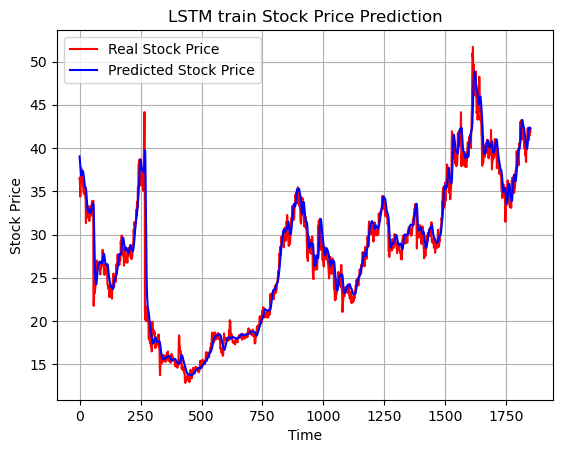

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  10.54  10.53  10.68  10.48  25159217  10.542  10.647   
14  2014/1/22  10.56  10.70  10.78  10.48  50123656  10.564  10.654   
15  2014/1/23  10.67  10.52  10.71  10.49  38634112  10.558  10.636   
16  2014/1/24  10.48  10.43  10.56  10.39  52264195  10.530  10.599   
17  2014/1/27  10.40  10.33  10.43  10.28  47078702  10.502  10.544   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  10.611207  10.652860 -0.041652    -0.024052  41.666667  
14  10.624868  10.656352 -0.031484    -0.025538  48.905109  
15  10.608734  10.646251 -0.037517    -0.027934  50.375940  
16  10.581237  10.630233 -0.048996    -0.032147  48.905109  
17  10.542585  10.607993 -0.065409    -0.038799  43.262411  
Epoch 1/20, Loss: 0.1077, Val Loss: 0.0133
Epoch 2/20, Loss: 0.0462, Val Loss: 0.0143
Epoch 3/20, Loss: 0.0119, Val Loss: 0.0120
Epoch 4/20, Loss: 0.0060, Val Loss: 0.0080
Epoch 5/20, Loss: 0.0041, Val Loss:

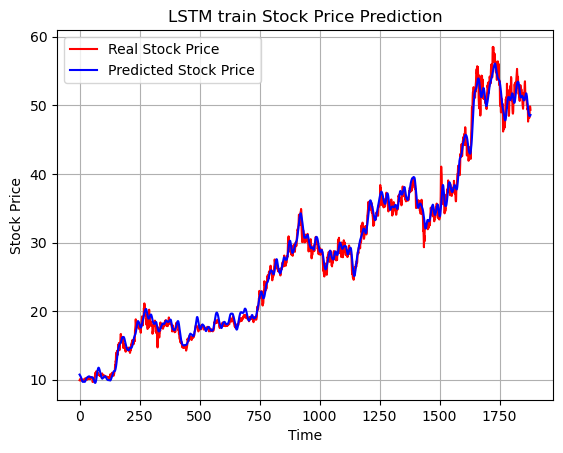

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  21.38  20.99  21.62  20.89   6552163  21.098  21.416   
14  2014/1/22  21.04  21.94  22.29  21.04  13154871  21.200  21.322   
15  2014/1/23  21.79  22.06  22.58  21.67   8683683  21.406  21.328   
16  2014/1/24  22.05  21.95  22.49  21.85   8115119  21.666  21.434   
17  2014/1/27  21.80  21.84  22.20  21.76   5411305  21.756  21.510   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  21.673044  22.429736 -0.756692    -0.613172  29.295775  
14  21.714114  22.393460 -0.679345    -0.626407  37.639752  
15  21.767328  22.368759 -0.601431    -0.621412  41.069100  
16  21.795431  22.337740 -0.542309    -0.605591  46.187683  
17  21.802288  22.300870 -0.498582    -0.584189  44.329897  
Epoch 1/20, Loss: 0.0504, Val Loss: 0.0241
Epoch 2/20, Loss: 0.0275, Val Loss: 0.0035
Epoch 3/20, Loss: 0.0163, Val Loss: 0.0013
Epoch 4/20, Loss: 0.0074, Val Loss: 0.0009
Epoch 5/20, Loss: 0.0058, Val Loss:

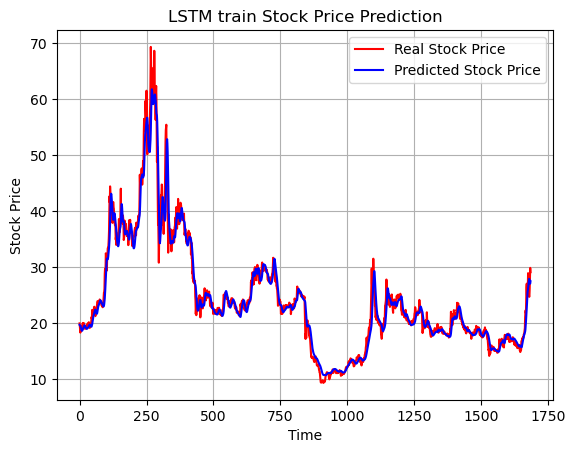

         date  open  close  high   low     volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  2.98   3.00  3.01  2.97   32935555  2.990   2.986  3.007215   
14  2014/1/22  3.00   3.07  3.08  2.99   97950702  3.008   2.992  3.016874   
15  2014/1/23  3.05   3.02  3.06  2.99  103151292  3.010   2.993  3.017355   
16  2014/1/24  3.01   3.04  3.07  3.00   71985253  3.022   2.999  3.020839   
17  2014/1/27  3.01   3.00  3.02  2.99   65211733  3.026   3.004  3.017633   

      EMA_26      MACD  Signal_Line     RSI_14  
13  3.044893 -0.037678    -0.034664  29.032258  
14  3.046752 -0.029878    -0.033707  42.105263  
15  3.044771 -0.027416    -0.032448  42.105263  
16  3.044417 -0.023578    -0.030674  51.428571  
17  3.041127 -0.023494    -0.029238  44.736842  
Epoch 1/20, Loss: 0.1656, Val Loss: 0.0652
Epoch 2/20, Loss: 0.0412, Val Loss: 0.0060
Epoch 3/20, Loss: 0.0226, Val Loss: 0.0010
Epoch 4/20, Loss: 0.0090, Val Loss: 0.0011
Epoch 5/20, Loss: 0.0072, Val Loss: 0.0008
Epoch 6/20, Loss: 0.00

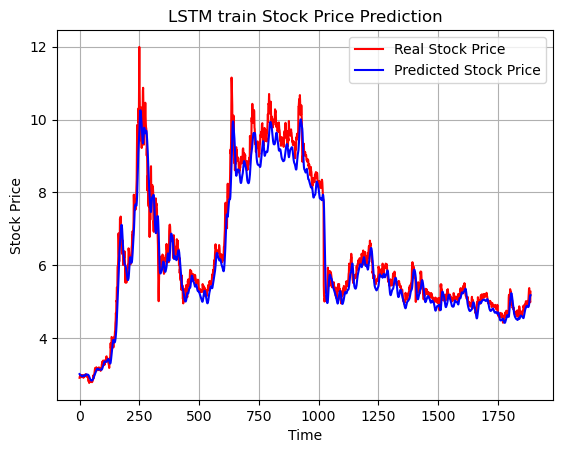

         date  open  close  high   low    volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  4.58   4.61  4.65  4.56  20238643  4.632   4.544  4.556001   
14  2014/1/22  4.60   4.65  4.66  4.59  37143152  4.632   4.570  4.570462   
15  2014/1/23  4.61   4.58  4.62  4.54  37685572  4.624   4.588  4.571929   
16  2014/1/24  4.57   4.60  4.61  4.55  28579969  4.612   4.606  4.576248   
17  2014/1/27  4.57   4.52  4.57  4.49  33444632  4.592   4.610  4.567594   

      EMA_26      MACD  Signal_Line     RSI_14  
13  4.511526  0.044474     0.023454  61.538462  
14  4.521784  0.048678     0.028498  63.768116  
15  4.526096  0.045833     0.031965  64.705882  
16  4.531570  0.044678     0.034508  60.000000  
17  4.530713  0.036881     0.034982  60.000000  
Epoch 1/20, Loss: 0.0457, Val Loss: 0.0568
Epoch 2/20, Loss: 0.0199, Val Loss: 0.0079
Epoch 3/20, Loss: 0.0069, Val Loss: 0.0023
Epoch 4/20, Loss: 0.0043, Val Loss: 0.0010
Epoch 5/20, Loss: 0.0032, Val Loss: 0.0006
Epoch 6/20, Loss: 0.0030, Va

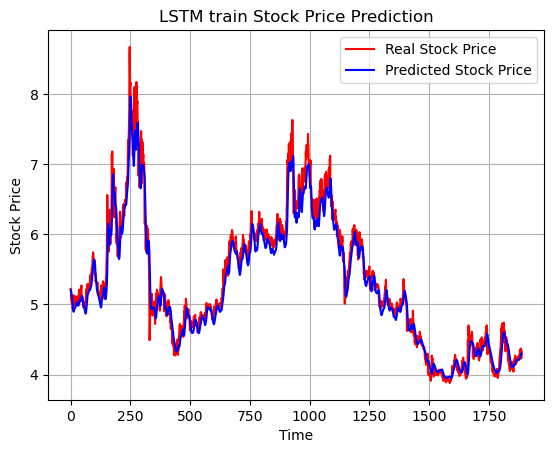

         date  open  close  high   low    volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  7.63   7.63  7.69  7.60   6845930  7.626   7.606  7.631028   
14  2014/1/22  7.63   7.69  7.70  7.61  14670507  7.648   7.611  7.640101   
15  2014/1/23  7.67   7.62  7.67  7.61   9334920  7.664   7.614  7.637009   
16  2014/1/24  7.60   7.62  7.65  7.59   7917304  7.638   7.623  7.634392   
17  2014/1/27  7.59   7.52  7.60  7.51  11967383  7.616   7.620  7.616793   

      EMA_26      MACD  Signal_Line     RSI_14  
13  7.643039 -0.012011    -0.013283  47.777778  
14  7.646518 -0.006417    -0.011910  51.041667  
15  7.644554 -0.007545    -0.011037  49.000000  
16  7.642735 -0.008343    -0.010498  41.379310  
17  7.633643 -0.016850    -0.011769  38.297872  
Epoch 1/20, Loss: 0.0818, Val Loss: 0.0682
Epoch 2/20, Loss: 0.0302, Val Loss: 0.0242
Epoch 3/20, Loss: 0.0144, Val Loss: 0.0038
Epoch 4/20, Loss: 0.0063, Val Loss: 0.0006
Epoch 5/20, Loss: 0.0042, Val Loss: 0.0006
Epoch 6/20, Loss: 0.0033, Va

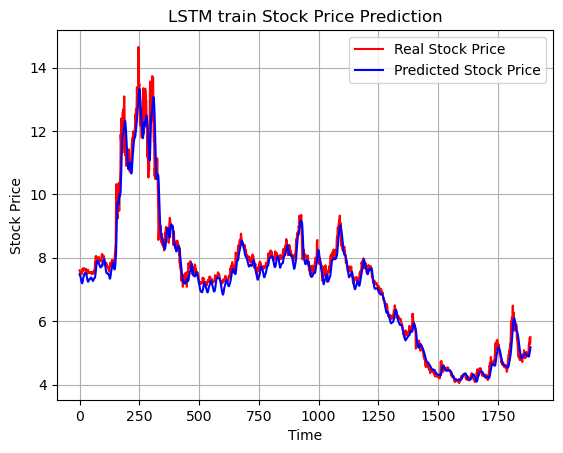

         date   open  close   high    low   volume   SMA_5  SMA_10     EMA_12  \
13  2014/1/21  34.20  34.46  34.69  34.00  1197448  34.392  33.940  34.166211   
14  2014/1/22  34.50  34.86  35.05  34.50  3853528  34.400  34.183  34.272948   
15  2014/1/23  35.18  35.62  35.86  35.01  4852626  34.586  34.503  34.480186   
16  2014/1/24  35.40  35.38  35.82  35.33  3122553  34.906  34.627  34.618619   
17  2014/1/27  35.02  35.47  36.00  34.66  3827558  35.158  34.820  34.749601   

       EMA_26      MACD  Signal_Line     RSI_14  
13  34.232860 -0.066649    -0.152553  48.593350  
14  34.279315 -0.006367    -0.123316  51.094891  
15  34.378625  0.101562    -0.078341  57.741560  
16  34.452801  0.165819    -0.029509  64.415584  
17  34.528149  0.221452     0.020684  64.690722  
Epoch 1/20, Loss: 0.0590, Val Loss: 0.0505
Epoch 2/20, Loss: 0.0265, Val Loss: 0.0571
Epoch 3/20, Loss: 0.0064, Val Loss: 0.0342
Epoch 4/20, Loss: 0.0042, Val Loss: 0.0116
Epoch 5/20, Loss: 0.0033, Val Loss: 0.003

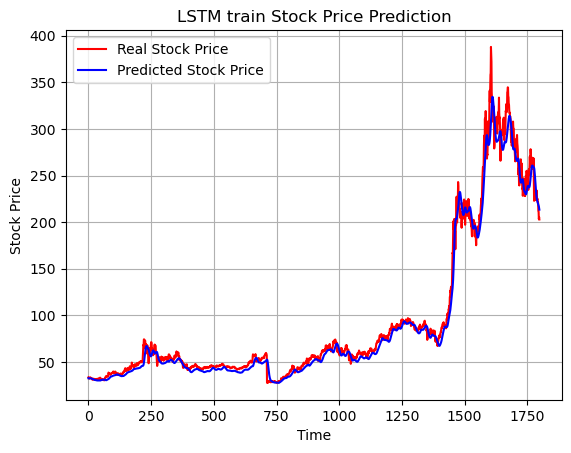

         date  open  close  high   low    volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  2.38   2.42  2.42  2.38  16615889  2.396   2.402  2.439805   
14  2014/1/22  2.42   2.48  2.48  2.41  27341406  2.412   2.406  2.445989   
15  2014/1/23  2.48   2.45  2.48  2.45  15533830  2.422   2.407  2.446606   
16  2014/1/24  2.45   2.46  2.47  2.44  19128181  2.438   2.415  2.448667   
17  2014/1/27  2.44   2.41  2.45  2.40  22666619  2.444   2.418  2.442718   

      EMA_26      MACD  Signal_Line     RSI_14  
13  2.512457 -0.072652    -0.064354  16.216216  
14  2.510053 -0.064064    -0.064296  27.906977  
15  2.505605 -0.058999    -0.063236  29.268293  
16  2.502226 -0.053560    -0.061301  41.935484  
17  2.495395 -0.052677    -0.059576  38.235294  
Epoch 1/20, Loss: 0.0332, Val Loss: 0.0147
Epoch 2/20, Loss: 0.0197, Val Loss: 0.0048
Epoch 3/20, Loss: 0.0079, Val Loss: 0.0004
Epoch 4/20, Loss: 0.0044, Val Loss: 0.0004
Epoch 5/20, Loss: 0.0028, Val Loss: 0.0003
Epoch 6/20, Loss: 0.0020, Va

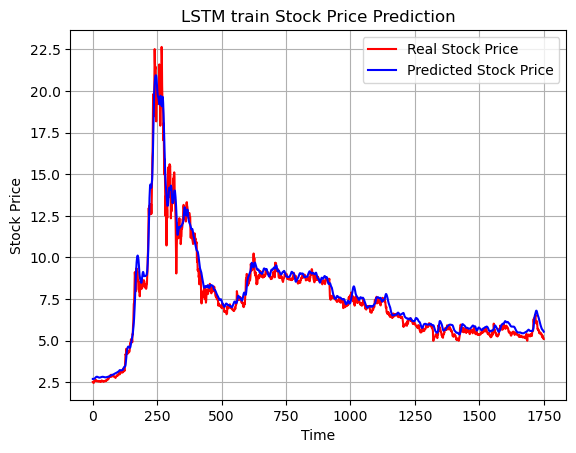

         date   open  close   high    low    volume   SMA_5  SMA_10  \
13  2014/1/21  11.55  11.71  11.88  11.55  61670690  11.578  11.631   
14  2014/1/22  11.80  12.08  12.12  11.73  96449941  11.702  11.631   
15  2014/1/23  12.06  11.91  12.09  11.83  72409099  11.772  11.640   
16  2014/1/24  11.84  11.96  12.11  11.82  72182788  11.834  11.684   
17  2014/1/27  11.85  11.56  11.90  11.52  95808522  11.844  11.698   

       EMA_12     EMA_26      MACD  Signal_Line     RSI_14  
13  11.760005  12.026563 -0.266558    -0.233772  28.640777  
14  11.809235  12.030521 -0.221286    -0.231275  39.506173  
15  11.824737  12.021594 -0.196857    -0.224391  42.857143  
16  11.845547  12.017031 -0.171484    -0.213810  44.104803  
17  11.801616  11.983177 -0.181561    -0.207360  40.400000  
Epoch 1/20, Loss: 0.1056, Val Loss: 0.0272
Epoch 2/20, Loss: 0.0373, Val Loss: 0.0040
Epoch 3/20, Loss: 0.0186, Val Loss: 0.0042
Epoch 4/20, Loss: 0.0075, Val Loss: 0.0026
Epoch 5/20, Loss: 0.0060, Val Loss:

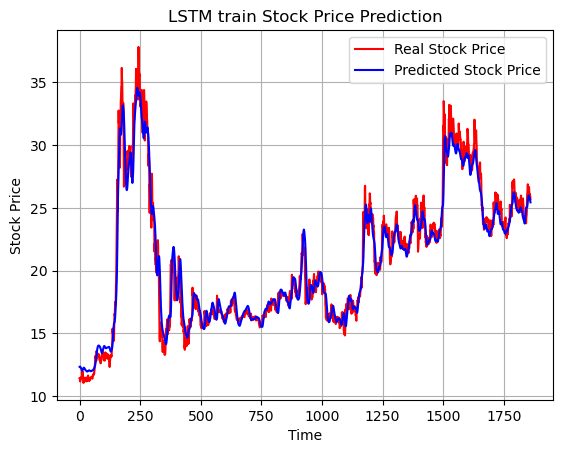

         date  open  close  high   low   volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  3.06   3.07  3.12  3.05  5295857  3.078   3.075  3.106596   
14  2014/1/22  3.07   3.14  3.15  3.06  6127687  3.092   3.078  3.111735   
15  2014/1/23  3.14   3.11  3.14  3.10  5903087  3.098   3.081  3.111468   
16  2014/1/24  3.11   3.14  3.15  3.08  4973543  3.102   3.090  3.115858   
17  2014/1/27  3.13   3.17  3.18  3.11  6856488  3.126   3.102  3.124187   

      EMA_26      MACD  Signal_Line     RSI_14  
13  3.166086 -0.059490    -0.053601  25.531915  
14  3.164154 -0.052419    -0.053364  35.185185  
15  3.160143 -0.048674    -0.052426  38.000000  
16  3.158651 -0.042793    -0.050500  52.380952  
17  3.159491 -0.035304    -0.047461  52.380952  
Epoch 1/20, Loss: 0.0305, Val Loss: 0.0662
Epoch 2/20, Loss: 0.0175, Val Loss: 0.0024
Epoch 3/20, Loss: 0.0050, Val Loss: 0.0161
Epoch 4/20, Loss: 0.0030, Val Loss: 0.0047
Epoch 5/20, Loss: 0.0026, Val Loss: 0.0032
Epoch 6/20, Loss: 0.0024, Val Loss

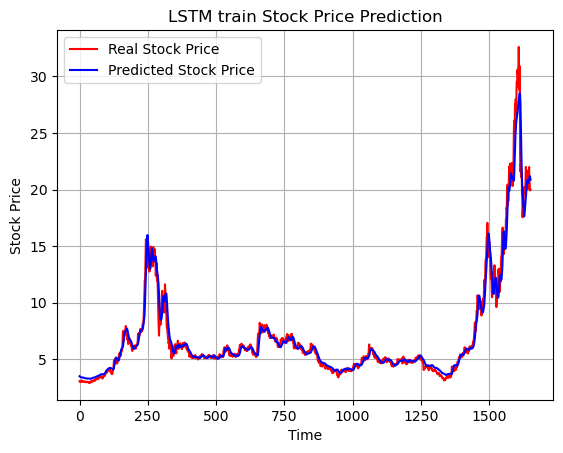

         date  open  close  high   low    volume  SMA_5  SMA_10    EMA_12  \
13  2014/1/21  2.21   2.22  2.23  2.20  18583974  2.218   2.221  2.236518   
14  2014/1/22  2.21   2.25  2.25  2.21  38418404  2.224   2.222  2.238592   
15  2014/1/23  2.23   2.23  2.25  2.22  22797579  2.224   2.224  2.237270   
16  2014/1/24  2.24   2.27  2.28  2.23  51598967  2.236   2.231  2.242305   
17  2014/1/27  2.25   2.26  2.29  2.23  43650301  2.246   2.233  2.245028   

      EMA_26      MACD  Signal_Line     RSI_14  
13  2.266285 -0.029768    -0.025707  26.086957  
14  2.265079 -0.026487    -0.025863  34.615385  
15  2.262481 -0.025210    -0.025733  36.000000  
16  2.263038 -0.020732    -0.024733  50.000000  
17  2.262813 -0.017785    -0.023343  48.148148  
Epoch 1/20, Loss: 0.0428, Val Loss: 0.1282
Epoch 2/20, Loss: 0.0129, Val Loss: 0.0037
Epoch 3/20, Loss: 0.0028, Val Loss: 0.0064
Epoch 4/20, Loss: 0.0024, Val Loss: 0.0056
Epoch 5/20, Loss: 0.0020, Val Loss: 0.0044
Epoch 6/20, Loss: 0.0018, Va

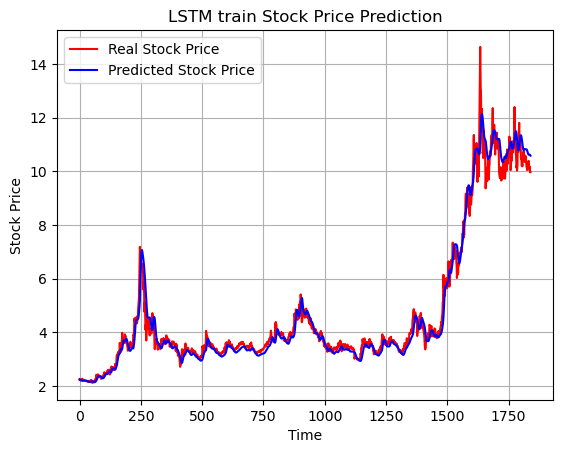

In [35]:
# apply this method for all data
# Directory containing the data files
data_dir = 'data/'
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# List all CSV files in the data directory
csv_files = [file for file in os.listdir(data_dir) if file.endswith('.csv')]
csv_files


for csv_file in csv_files:
    # 读取数据
    if csv_file == 'dianxin.csv' or csv_file == 'haiguang.csv' or csv_file == 'jinshanbangong.csv' or csv_file == 'sanxia.csv' or csv_file == 'tianhe.csv' or csv_file == 'zhongxinguoji.csv':
        continue
    dir = os.path.join(data_dir, csv_file)
    data = pd.read_csv(dir, skiprows=2)
    data = data[(data != 0).all(axis=1)]

    # 计算指标
    data['SMA_5'] = data['close'].rolling(window=5).mean()
    data['SMA_10'] = data['close'].rolling(window=10).mean()
    data['EMA_12'] = data['close'].ewm(span=12, adjust=False).mean()
    data['EMA_26'] = data['close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    def calculate_rsi(data, window):
        delta = data['close'].diff(1)
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)
        avg_gain = pd.Series(gain).rolling(window=window).mean()
        avg_loss = pd.Series(loss).rolling(window=window).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    data['RSI_14'] = calculate_rsi(data, 14)
    data.dropna(inplace=True)
    print(data.head())

    # 选择特征
    all_data = data.loc[:, ['open', 'close', 'high', 'low', 'volume', 'SMA_5', 'SMA_10', 'EMA_12', 'EMA_26', 'MACD', 'Signal_Line', 'RSI_14']]
    sc = MinMaxScaler(feature_range=(0, 1))
    # run all_data_scaled = sc.fit_transform(all_data), if raise value error then continue
    try:
        all_data_scaled = sc.fit_transform(all_data)
    except ValueError:
        continue
    timestep = 60
    features, labels = [], []
    for i in range(timestep, len(all_data_scaled)):
        features.append(all_data_scaled[i - timestep:i])
        labels.append(all_data_scaled[i, 1])

    features, labels = np.array(features), np.array(labels)
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)
    train_size = int(len(features) * 0.8)
    val_size = int(len(features) * 0.1)

    x_train, y_train = features[:train_size], labels[:train_size]
    x_val, y_val = features[train_size:train_size+val_size], labels[train_size:train_size+val_size]
    x_test, y_test = features[train_size+val_size:], labels[train_size+val_size:]
    model = LSTMModel(input_size, hidden_size, num_layers, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_epochs = 20
    batch_size = 128

    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    history = {'loss': [], 'val_loss': []}
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        model.eval()
    sc_one = MinMaxScaler(feature_range=(0, 1))
    sc_one.fit(all_data.iloc[:, 1:2])

    predicted_stock_train = model(x_train).detach().numpy()
    predicted_stock_train = sc_one.inverse_transform(predicted_stock_train)
    predicted_stock_test = model(x_test).detach().numpy()
    predicted_stock_test = sc_one.inverse_transform(predicted_stock_test)

    real_price_train = sc_one.inverse_transform(y_train.numpy())
    real_price_test = sc_one.inverse_transform(y_test.numpy())
    mse = mean_squared_error(predicted_stock_test, real_price_test)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(predicted_stock_test, real_price_test)
    mape = mean_absolute_percentage_error(predicted_stock_test, real_price_test)
    r2 = r2_score(predicted_stock_test, real_price_test)

    print(f'MSE: {mse:.6f}')
    print(f'RMSE: {rmse:.6f}')
    print(f'MAE: {mae:.6f}')
    print(f'MAPE: {mape:.6f}')
    print(f'R^2: {r2:.6f}')
    plt.plot(real_price_train, color='red', label='Real Stock Price')
    plt.plot(predicted_stock_train, color='blue', label='Predicted Stock Price')
    plt.title('LSTM train Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()